Block 1: Setup and Data Acquisition
This block handles all the necessary setup, including installing libraries and reliably downloading the GTSRB dataset from Kaggle.

Instructions:

Run this code cell first.

When prompted, upload your kaggle.json file to authenticate.

In [2]:
import os
import zipfile
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# --- Step 1: Download GTSRB Dataset from Kaggle ---
try:
    # Install Kaggle API
    print("Installing Kaggle API...")
    os.system("pip install -q kaggle")

    # Authenticate with Kaggle API token
    print("Please upload your kaggle.json file. Click 'Choose Files' below.")
    from google.colab import files
    files.upload()

    # Move the uploaded kaggle.json to the correct directory and set permissions
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    os.rename("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    print("Kaggle authentication complete.")

    # Define Kaggle dataset details and download path
    kaggle_dataset = 'meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'
    zip_path = 'gtsrb-german-traffic-sign.zip'
    extract_path = 'GTSRB'

    # Download the dataset
    print(f"\nDownloading dataset from Kaggle: {kaggle_dataset}...")
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {extract_path}")

    # Unzip the dataset
    print(f"Unzipping {zip_path}...")
    with zipfile.ZipFile(os.path.join(extract_path, zip_path), 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Unzipping complete.")

except Exception as e:
    print(f"An error occurred during setup or data acquisition: {e}")
    print("Please ensure your kaggle.json file is valid and you have a stable internet connection.")

Installing Kaggle API...
Please upload your kaggle.json file. Click 'Choose Files' below.


Saving kaggle.json to kaggle.json
Kaggle authentication complete.

Unzipping gtsrb-german-traffic-sign.zip...
Unzipping complete.


Block 2: Data Loading and Preprocessing

In [1]:
# --- Step 2: Data Loading and Preprocessing ---
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

data = []
labels = []
IMG_WIDTH = 32  # <-- Change this to 32
IMG_HEIGHT = 32 # <-- Change this to 32
NUM_CLASSES = 43 # There are 43 classes in the GTSRB dataset

# The GTSRB dataset has a specific folder structure (0, 1, 2, ... 42)
dataset_path = 'GTSRB/Train'

if not os.path.exists(dataset_path):
    print(f"Error: Dataset path not found at {dataset_path}")
else:
    print("\nLoading and preprocessing images...")
    for class_id in range(NUM_CLASSES):
        path = os.path.join(dataset_path, str(class_id))
        if not os.path.exists(path):
            print(f"Warning: Class folder {path} not found. Skipping.")
            continue

        images = os.listdir(path)
        for image_name in images:
            try:
                image_path = os.path.join(path, image_name)
                # Load the image and convert to RGB
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Preprocess: resize and normalize
                image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
                image = np.array(image) / 255.0 # Normalize pixel values

                data.append(image)
                labels.append(class_id)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}. Skipping.")

    data = np.array(data)
    labels = np.array(labels)

    print(f"Total images loaded: {len(data)}")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

    # Convert labels to one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")


Loading and preprocessing images...
Total images loaded: 39209
Training data shape: (31367, 32, 32, 3)
Testing data shape: (7842, 32, 32, 3)


Block 3: Train a Custom CNN Model

In [2]:
# --- Step 3: Build and Train a Custom CNN ---
print("\nBuilding and training a custom CNN model...")

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Correct way to define the input shape explicitly
model = Sequential([
    Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)), # This is the corrected line
    Conv2D(32, (5, 5), activation='relu'),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), verbose=1)

print("\nModel training complete.")


Building and training a custom CNN model...
Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.3648 - loss: 2.3612 - val_accuracy: 0.9540 - val_loss: 0.1623
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9104 - loss: 0.2912 - val_accuracy: 0.9848 - val_loss: 0.0678
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9505 - loss: 0.1643 - val_accuracy: 0.9894 - val_loss: 0.0432
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9685 - loss: 0.1078 - val_accuracy: 0.9925 - val_loss: 0.0311
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9698 - loss: 0.0997 - val_accuracy: 0.9916 - val_loss: 0.0331
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9773 - loss: 0.0727 - val_accuracy: 0.9926 - val_loss: 0.0277
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9798 - loss: 0.0655 - val_accuracy: 0.9949 - val_loss: 0.0210
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc

Block 4: Evaluate Model Performance


Evaluating model performance...
Test Loss: 0.0168
Test Accuracy: 0.9959
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


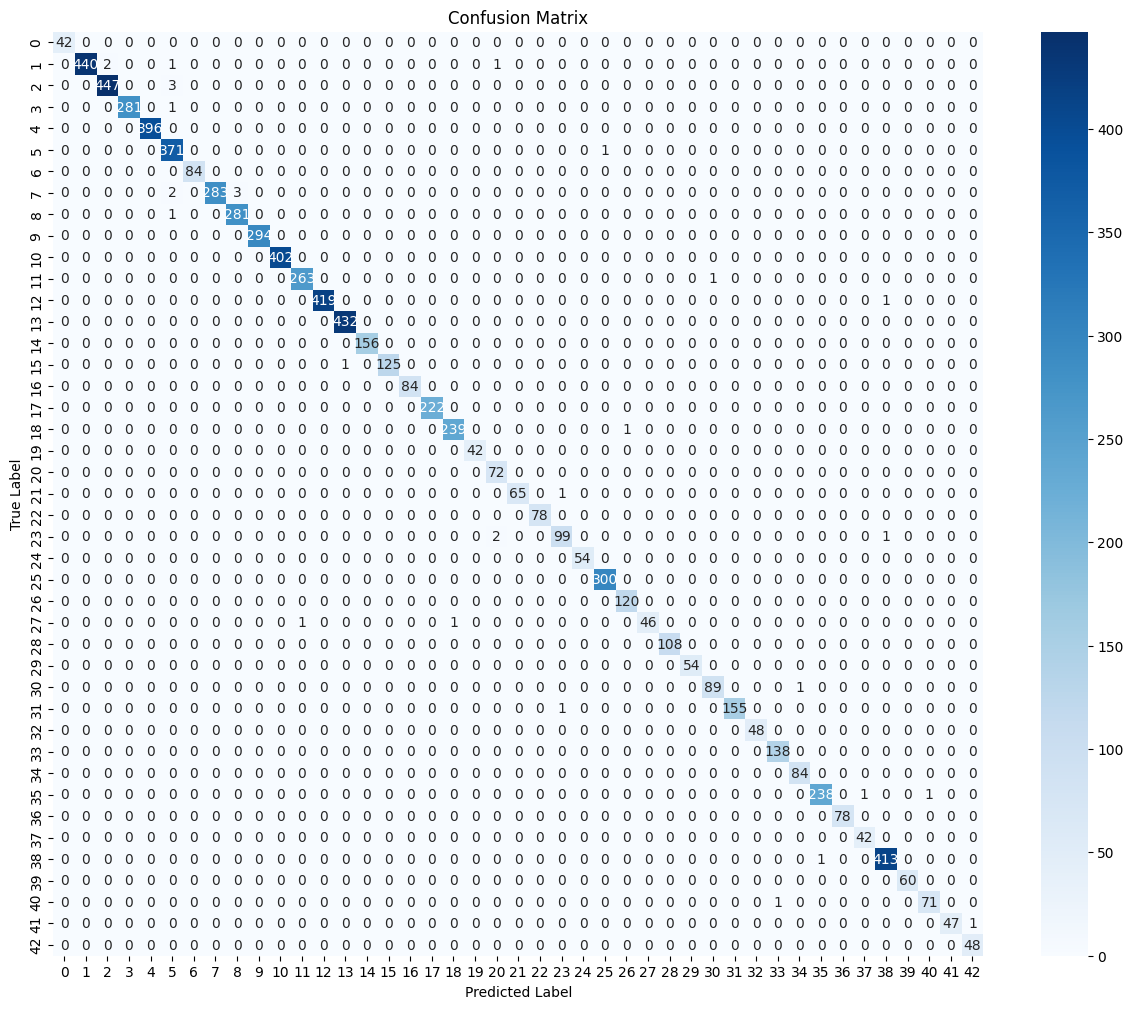


Evaluation complete. The confusion matrix shows model performance per class.


In [5]:
# --- Step 4: Evaluate Performance ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\nEvaluating model performance...")

# Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate and plot confusion matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nEvaluation complete. The confusion matrix shows model performance per class.")

Block 5 (Bonus): Data Augmentation and Transfer Learning

In [7]:
# --- Step 5 (Bonus): Data Augmentation and Transfer Learning ---
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

print("\nTraining with Data Augmentation and a pre-trained model (MobileNetV2)...")

# --- Part A: Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)
datagen.fit(X_train)

# --- Part B: Transfer Learning with MobileNetV2 ---
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Freeze the base model

# Create the new model on top of the base model
transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(128, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(NUM_CLASSES, activation='softmax'))

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the data generator
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    history_transfer = transfer_model.fit(
        datagen.flow(X_train, y_train, batch_size=64),
        epochs=15,
        validation_data=(X_test, y_test),
        verbose=1
    )

print("\nTraining with Data Augmentation and MobileNetV2 complete.")


Training with Data Augmentation and a pre-trained model (MobileNetV2)...


/tmp/ipython-input-1686982314.py:25: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - accuracy: 0.1389 - loss: 3.2968 - val_accuracy: 0.2595 - val_loss: 2.6455
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.2331 - loss: 2.6720 - val_accuracy: 0.2853 - val_loss: 2.4877
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.2587 - loss: 2.5590 - val_accuracy: 0.3001 - val_loss: 2.4090
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.2679 - loss: 2.4975 - val_accuracy: 0.3050 - val_loss: 2.3665
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.2724 - loss: 2.4562 - val_accuracy: 0.3199 - val_loss: 2.3319
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.2821 - loss: 2.4356 - val_accuracy: 0.3194 - val_loss: 2.3020
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.2930 - loss: 2.3839 - val_accuracy: 0.3182 - val_loss: 2.2879
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2